# Train with Pseudo Labels

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../src")

In [57]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import metrics
from scipy.special import softmax

import torch
import torch.nn as nn
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
import pretrainedmodels

import dataset
import engine
import models

## Data

In [20]:
device = torch.device("cuda")
df = pd.read_csv("../input/pl3/train_pl3.csv")
df.shape

(15884, 788)

## Baseline

Epoch=0, Accuracy=0.8347497639282342
Epoch=10, Accuracy=0.9625432798237331
Epoch=20, Accuracy=0.9660056657223796
Epoch=30, Accuracy=0.9760780610638967
Epoch=40, Accuracy=0.9735599622285175
Epoch=50, Accuracy=0.9735599622285175
Epoch=60, Accuracy=0.9773371104815864
Epoch=70, Accuracy=0.9789109222536985
Epoch=80, Accuracy=0.9801699716713881
Epoch=90, Accuracy=0.9782813975448537
Epoch=100, Accuracy=0.9811142587346553
Epoch=110, Accuracy=0.9814290210890777
Epoch=120, Accuracy=0.9830028328611898
Epoch=130, Accuracy=0.9820585457979226
Epoch=140, Accuracy=0.9848914069877243
Epoch=150, Accuracy=0.9826880705067674
Epoch=160, Accuracy=0.9848914069877243
Epoch=170, Accuracy=0.9874095058231036
Epoch=180, Accuracy=0.9870947434686811
Epoch=190, Accuracy=0.9845766446333019
Fold=0, Validation Accuracy=0.9848914069877243


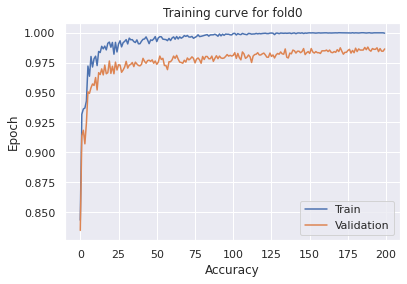

Epoch=0, Accuracy=0.8120868744098206
Epoch=10, Accuracy=0.9597104186339314
Epoch=20, Accuracy=0.9710418633931381
Epoch=30, Accuracy=0.9685237645577589
Epoch=40, Accuracy=0.9795404469625433
Epoch=50, Accuracy=0.9748190116462071
Epoch=60, Accuracy=0.9776518728360089
Epoch=70, Accuracy=0.9785961598992761
Epoch=80, Accuracy=0.9836323575700346
Epoch=90, Accuracy=0.9785961598992761
Epoch=100, Accuracy=0.9763928234183191
Epoch=110, Accuracy=0.9820585457979226
Epoch=120, Accuracy=0.9814290210890777
Epoch=130, Accuracy=0.9811142587346553
Epoch=140, Accuracy=0.9826880705067674
Epoch=150, Accuracy=0.9817437834435001
Epoch=160, Accuracy=0.9836323575700346
Epoch=170, Accuracy=0.9845766446333019
Epoch=180, Accuracy=0.9845766446333019
Epoch=190, Accuracy=0.9855209316965691
Fold=1, Validation Accuracy=0.9845766446333019


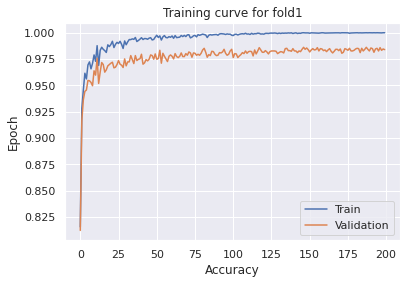

Epoch=0, Accuracy=0.8293988039030532
Epoch=10, Accuracy=0.9634875668870003
Epoch=20, Accuracy=0.9719861504564055
Epoch=30, Accuracy=0.9732451998740951
Epoch=40, Accuracy=0.9700975763298709
Epoch=50, Accuracy=0.9801699716713881
Epoch=60, Accuracy=0.9757632987094743
Epoch=70, Accuracy=0.9807994963802329
Epoch=80, Accuracy=0.9845766446333019
Epoch=90, Accuracy=0.9817437834435001
Epoch=100, Accuracy=0.9826880705067674
Epoch=110, Accuracy=0.9836323575700346
Epoch=120, Accuracy=0.9858356940509915
Epoch=130, Accuracy=0.9864652187598363
Epoch=140, Accuracy=0.9861504564054139
Epoch=150, Accuracy=0.9864652187598363
Epoch=160, Accuracy=0.9833175952156122
Epoch=170, Accuracy=0.9864652187598363
Epoch=180, Accuracy=0.982373308152345
Epoch=190, Accuracy=0.9867799811142587
Fold=2, Validation Accuracy=0.983947119924457


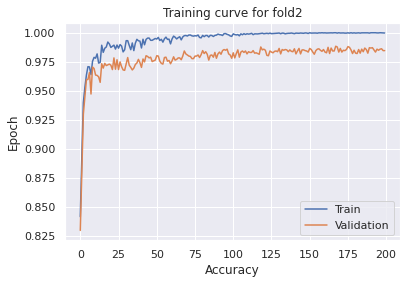

Epoch=0, Accuracy=0.7752596789423984
Epoch=10, Accuracy=0.9666351904312245
Epoch=20, Accuracy=0.9723009128108279
Epoch=30, Accuracy=0.9789109222536985
Epoch=40, Accuracy=0.9631728045325779
Epoch=50, Accuracy=0.9760780610638967
Epoch=60, Accuracy=0.9767075857727415
Epoch=70, Accuracy=0.9776518728360089
Epoch=80, Accuracy=0.9763928234183191
Epoch=90, Accuracy=0.9773371104815864
Epoch=100, Accuracy=0.9779666351904313
Epoch=110, Accuracy=0.977022348127164
Epoch=120, Accuracy=0.9798552093169657
Epoch=130, Accuracy=0.9807994963802329
Epoch=140, Accuracy=0.9852061693421467
Epoch=150, Accuracy=0.9820585457979226
Epoch=160, Accuracy=0.9804847340258105
Epoch=170, Accuracy=0.9842618822788795
Epoch=180, Accuracy=0.9842618822788795
Epoch=190, Accuracy=0.9842618822788795
Fold=3, Validation Accuracy=0.9845766446333019


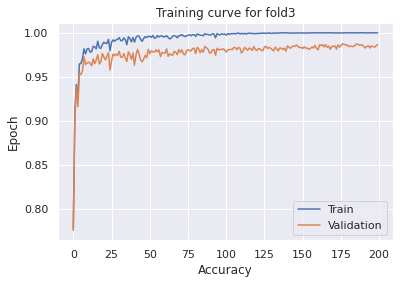

Epoch=0, Accuracy=0.7981738035264484
Epoch=10, Accuracy=0.9549748110831234
Epoch=20, Accuracy=0.970088161209068
Epoch=30, Accuracy=0.9763853904282116
Epoch=40, Accuracy=0.9751259445843828
Epoch=50, Accuracy=0.9795340050377834
Epoch=60, Accuracy=0.9801637279596978
Epoch=70, Accuracy=0.9785894206549118
Epoch=80, Accuracy=0.9798488664987406
Epoch=90, Accuracy=0.9811083123425692
Epoch=100, Accuracy=0.9852015113350125
Epoch=110, Accuracy=0.9826826196473551
Epoch=120, Accuracy=0.9833123425692695
Epoch=130, Accuracy=0.9861460957178841
Epoch=140, Accuracy=0.9842569269521411
Epoch=150, Accuracy=0.985831234256927
Epoch=160, Accuracy=0.9870906801007556
Epoch=170, Accuracy=0.9842569269521411
Epoch=180, Accuracy=0.9874055415617129
Epoch=190, Accuracy=0.9867758186397985
Fold=4, Validation Accuracy=0.9874055415617129


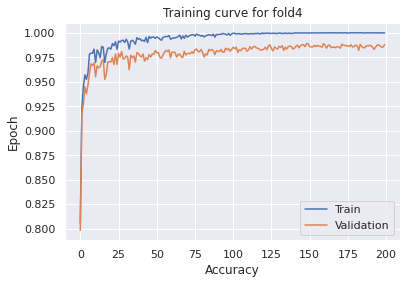

In [58]:
# Baseline
EPOCHS = 200
oof = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))
SWA = False

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = models.Model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    if SWA:
        swa_start = int(0.75 * EPOCHS)
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        swa_model = AveragedModel(model).to(device)
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        if SWA and epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")
    
    if SWA:
        # Update BN-statistics
        swa_model = swa_model.cpu()
        update_bn(train_loader, swa_model)
        swa_model.to(device)
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model if SWA else model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()

    oof[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/baseline-swa{SWA}-{fold}.pth")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-baseline-swa{SWA}", oof)
np.save("../input/processed/targs-train-oof", targs_oof)

In [61]:
# oof = np.load("../input/processed/oof-train-baseline-swa.npy")
# targs_oof = np.load("../input/processed/targs-train-oof.npy")
preds_oof = np.argmax(oof, axis=1)
accuracy_oof = metrics.accuracy_score(targs_oof, preds_oof)
print(f"CV Accuracy Score={accuracy_oof}")

CV Accuracy Score=0.9850793251070259


In [67]:
EXP = -0.9
s = pd.Series(preds_oof)
vc = s.value_counts().sort_index()
mat = np.diag(vc.astype(np.float32) ** (EXP))

probs_oof_post = oof.dot(mat)
preds_oof_post = np.argmax(probs_oof_post, axis=1)
print(f"Post-processing CV Accuracy score={metrics.accuracy_score(targs_oof, preds_oof_post)}")

Post-processing CV Accuracy score=0.9852681944094687


## SpinalVGG

Epoch=0, Accuracy=0.9159584513692163
Epoch=10, Accuracy=0.9767075857727415
Epoch=20, Accuracy=0.9741894869373623
Epoch=30, Accuracy=0.987724268177526
Epoch=40, Accuracy=0.9789109222536985
Epoch=50, Accuracy=0.9902423670129052
Epoch=60, Accuracy=0.9855209316965691
Epoch=70, Accuracy=0.989298079949638
Epoch=80, Accuracy=0.982373308152345
Epoch=90, Accuracy=0.9880390305319484
Epoch=100, Accuracy=0.9886685552407932
Epoch=110, Accuracy=0.9874095058231036
Epoch=120, Accuracy=0.989298079949638
Epoch=130, Accuracy=0.9899276046584828
Epoch=140, Accuracy=0.9902423670129052
Epoch=150, Accuracy=0.9905571293673276
Epoch=160, Accuracy=0.9899276046584828
Epoch=170, Accuracy=0.9902423670129052
Epoch=180, Accuracy=0.9911866540761725
Epoch=190, Accuracy=0.9795404469625433
Fold=0, Validation Accuracy=0.9918161787850173


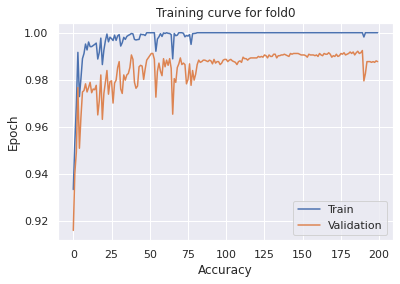

Epoch=0, Accuracy=0.8083097261567517
Epoch=10, Accuracy=0.9773371104815864
Epoch=20, Accuracy=0.9713566257475605
Epoch=30, Accuracy=0.9820585457979226
Epoch=40, Accuracy=0.9732451998740951
Epoch=50, Accuracy=0.9729304375196727
Epoch=60, Accuracy=0.9836323575700346
Epoch=70, Accuracy=0.9826880705067674
Epoch=80, Accuracy=0.9858356940509915
Epoch=90, Accuracy=0.9830028328611898
Epoch=100, Accuracy=0.9842618822788795
Epoch=110, Accuracy=0.9886685552407932
Epoch=120, Accuracy=0.9880390305319484
Epoch=130, Accuracy=0.987724268177526
Epoch=140, Accuracy=0.9886685552407932
Epoch=150, Accuracy=0.987724268177526
Epoch=160, Accuracy=0.9883537928863708
Epoch=170, Accuracy=0.9883537928863708
Epoch=180, Accuracy=0.9883537928863708
Epoch=190, Accuracy=0.9886685552407932
Fold=1, Validation Accuracy=0.9883537928863708


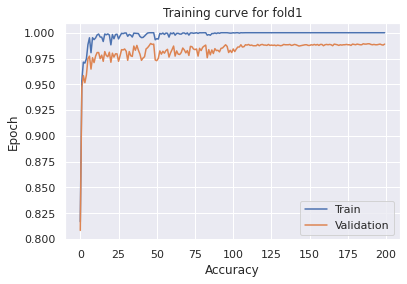

Epoch=0, Accuracy=0.9002203336480957
Epoch=10, Accuracy=0.9807994963802329
Epoch=20, Accuracy=0.9694680516210261
Epoch=30, Accuracy=0.9826880705067674
Epoch=40, Accuracy=0.9861504564054139
Epoch=50, Accuracy=0.9889833175952156
Epoch=60, Accuracy=0.9896128423040604
Epoch=70, Accuracy=0.9883537928863708
Epoch=80, Accuracy=0.9896128423040604
Epoch=90, Accuracy=0.9864652187598363
Epoch=100, Accuracy=0.9911866540761725
Epoch=110, Accuracy=0.9902423670129052
Epoch=120, Accuracy=0.9915014164305949
Epoch=130, Accuracy=0.9915014164305949
Epoch=140, Accuracy=0.9921309411394397
Epoch=150, Accuracy=0.9918161787850173
Epoch=160, Accuracy=0.987724268177526
Epoch=170, Accuracy=0.9911866540761725
Epoch=180, Accuracy=0.9905571293673276
Epoch=190, Accuracy=0.9896128423040604
Fold=2, Validation Accuracy=0.9905571293673276


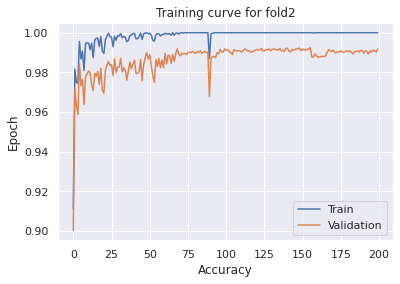

Epoch=0, Accuracy=0.9241422725841989
Epoch=10, Accuracy=0.9817437834435001
Epoch=20, Accuracy=0.9754485363550519
Epoch=30, Accuracy=0.9811142587346553
Epoch=40, Accuracy=0.9864652187598363
Epoch=50, Accuracy=0.9830028328611898
Epoch=60, Accuracy=0.9817437834435001
Epoch=70, Accuracy=0.9820585457979226
Epoch=80, Accuracy=0.9836323575700346
Epoch=90, Accuracy=0.9889833175952156
Epoch=100, Accuracy=0.9889833175952156
Epoch=110, Accuracy=0.9896128423040604
Epoch=120, Accuracy=0.989298079949638
Epoch=130, Accuracy=0.9896128423040604
Epoch=140, Accuracy=0.9902423670129052
Epoch=150, Accuracy=0.9889833175952156
Epoch=160, Accuracy=0.9899276046584828
Epoch=170, Accuracy=0.989298079949638
Epoch=180, Accuracy=0.9899276046584828
Epoch=190, Accuracy=0.989298079949638
Fold=3, Validation Accuracy=0.9902423670129052


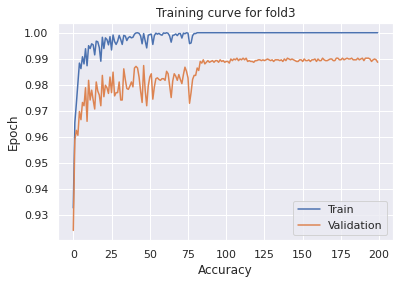

Epoch=0, Accuracy=0.8998740554156172
Epoch=10, Accuracy=0.9697732997481109
Epoch=20, Accuracy=0.9817380352644837
Epoch=30, Accuracy=0.9811083123425692
Epoch=40, Accuracy=0.9874055415617129
Epoch=50, Accuracy=0.9826826196473551
Epoch=60, Accuracy=0.9842569269521411
Epoch=70, Accuracy=0.9870906801007556
Epoch=80, Accuracy=0.9864609571788413
Epoch=90, Accuracy=0.9820528967254408
Epoch=100, Accuracy=0.9886649874055415
Epoch=110, Accuracy=0.9883501259445844
Epoch=120, Accuracy=0.9883501259445844
Epoch=130, Accuracy=0.989294710327456
Epoch=140, Accuracy=0.9899244332493703
Epoch=150, Accuracy=0.989294710327456
Epoch=160, Accuracy=0.989294710327456
Epoch=170, Accuracy=0.9889798488664987
Epoch=180, Accuracy=0.9880352644836272
Epoch=190, Accuracy=0.9896095717884131
Fold=4, Validation Accuracy=0.9896095717884131


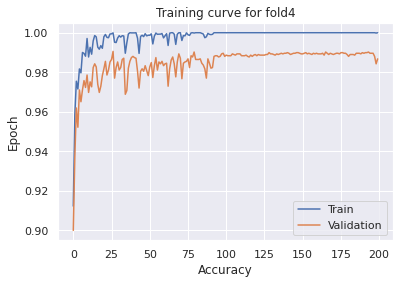

In [68]:
# SpinalVGG
EPOCHS = 200
oof_spinalvgg = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))
SWA = False

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = models.SpinalVGG().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    if SWA:
        swa_start = int(0.75 * EPOCHS)
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        swa_model = AveragedModel(model).to(device)
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        if SWA and epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        
        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")

    if SWA:
        # Update BN-stats
        swa_model = swa_model.cpu()
        update_bn(train_loader, swa_model)
        swa_model.to(device)
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model if SWA else model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
            
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()        
    
    oof_spinalvgg[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/spinalvgg-swa{SWA}-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
np.save("../input/processed/oof-train-spinalvgg-swa{SWA}", oof2)

In [69]:
# oof2 = np.load("../input/processed/oof-train-spinalvgg-swa.npy")
# targs_oof2 = np.load("../input/processed/targs-train-oof.npy")
preds_oof2 = np.argmax(oof2, axis=1)
accuracy_oof2 = metrics.accuracy_score(targs_oof2, preds_oof2)
print(f"CV Accuracy Score={accuracy_oof2}")

CV Accuracy Score=0.9901158398388316


## ResNet

In [30]:
def ResNet18(pretrained=None):
    model = pretrainedmodels.__dict__["resnet18"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet34(pretrained=None):
    model = pretrainedmodels.__dict__["resnet34"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model
    
def ResNet50(pretrained=None):
    model = pretrainedmodels.__dict__["resnet50"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet101(pretrained=None):
    model = pretrainedmodels.__dict__["resnet101"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet152(pretrained=None):
    model = pretrainedmodels.__dict__["resnet152"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

### ResNet18

In [57]:
# ResNet18
EPOCHS = 250
oof3 = np.zeros((len(df), 10))
targs_oof3 = np.zeros(len(df))

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    
    train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = ResNet18().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()

    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()
    
    oof3[valid_indices] = softmax(probs, axis=1)
    targs_oof3[valid_indices] = targs
    torch.save(model.state_dict(), f"../models/resnet18-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
np.save("../input/processed/oof-train-resnet18", oof3)

Epoch=0, Accuracy=0.6273213723638653
Epoch=10, Accuracy=0.9231979855209317
Epoch=20, Accuracy=0.9209946490399749
Epoch=30, Accuracy=0.9348441926345609
Epoch=40, Accuracy=0.9288637079005351
Epoch=50, Accuracy=0.9329556185080264
Epoch=60, Accuracy=0.9263456090651558
Epoch=70, Accuracy=0.9348441926345609
Epoch=80, Accuracy=0.947119924457035
Epoch=90, Accuracy=0.9458608750393452
Epoch=100, Accuracy=0.9559332703808624
Epoch=110, Accuracy=0.9575070821529745
Epoch=120, Accuracy=0.9578218445073969
Epoch=130, Accuracy=0.9587661315706641
Epoch=140, Accuracy=0.959395656279509
Epoch=150, Accuracy=0.959395656279509
Epoch=160, Accuracy=0.9575070821529745
Epoch=170, Accuracy=0.9600251809883538
Epoch=180, Accuracy=0.9603399433427762
Epoch=190, Accuracy=0.9603399433427762
Fold=0, Validation Accuracy=0.9584513692162417
Epoch=0, Accuracy=0.5914384639597104
Epoch=10, Accuracy=0.9128108278249921
Epoch=20, Accuracy=0.8467107333962858
Epoch=30, Accuracy=0.9376770538243626
Epoch=40, Accuracy=0.929807994963802

In [58]:
# oof3 = np.load("../input/processed/oof-train-resnet18")
# targs_oof3 = np.load("../input/processed/targs-train-oof.npy")
preds_oof3 = np.argmax(oof3, axis=1)
accuracy_oof3 = metrics.accuracy_score(targs_oof3, preds_oof3)
print(f"CV Accuracy Score={accuracy_oof3}")

CV Accuracy Score=0.9602744900528835


### ResNet34

Epoch=0, Accuracy=0.454831602140384
Epoch=10, Accuracy=0.869058860560277
Epoch=20, Accuracy=0.9058860560276991
Epoch=30, Accuracy=0.8781869688385269
Epoch=40, Accuracy=0.9062008183821215
Epoch=50, Accuracy=0.8892036512433114
Epoch=60, Accuracy=0.9427132514951212
Epoch=70, Accuracy=0.9401951526597419
Epoch=80, Accuracy=0.9282341831916903
Epoch=90, Accuracy=0.9323260937991816
Epoch=100, Accuracy=0.9584513692162417
Epoch=110, Accuracy=0.9600251809883538
Epoch=120, Accuracy=0.9515265974189487
Epoch=130, Accuracy=0.9537299338999056
Epoch=140, Accuracy=0.9493232609379918
Epoch=150, Accuracy=0.95561850802644
Epoch=160, Accuracy=0.9549889833175952
Epoch=170, Accuracy=0.9565627950897073
Epoch=180, Accuracy=0.9562480327352849
Epoch=190, Accuracy=0.9581366068618193
Epoch=200, Accuracy=0.9581366068618193
Epoch=210, Accuracy=0.9571923197985521
Epoch=220, Accuracy=0.9587661315706641
Epoch=230, Accuracy=0.9571923197985521
Epoch=240, Accuracy=0.9571923197985521
Fold=0, Validation Accuracy=0.9587661315

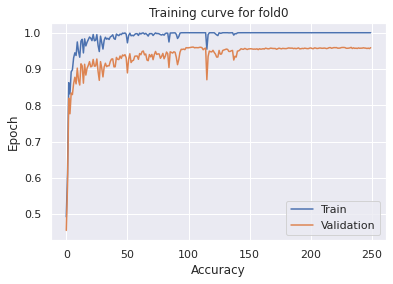

Epoch=0, Accuracy=0.5763298709474347
Epoch=10, Accuracy=0.8914069877242682
Epoch=20, Accuracy=0.9156436890147939
Epoch=30, Accuracy=0.9115517784073025
Epoch=40, Accuracy=0.9285489455461127
Epoch=50, Accuracy=0.9386213408876298
Epoch=60, Accuracy=0.9405099150141643
Epoch=70, Accuracy=0.9342146679257161
Epoch=80, Accuracy=0.9313818067359144
Epoch=90, Accuracy=0.9398803903053194
Epoch=100, Accuracy=0.9568775574441297
Epoch=110, Accuracy=0.95561850802644
Epoch=120, Accuracy=0.9575070821529745
Epoch=130, Accuracy=0.9562480327352849
Epoch=140, Accuracy=0.9575070821529745
Epoch=150, Accuracy=0.9575070821529745
Epoch=160, Accuracy=0.9575070821529745
Epoch=170, Accuracy=0.9590808939250866
Epoch=180, Accuracy=0.9531004091910608
Epoch=190, Accuracy=0.9512118350645263
Epoch=200, Accuracy=0.9508970727101038
Epoch=210, Accuracy=0.950267548001259
Epoch=220, Accuracy=0.9505823103556814
Epoch=230, Accuracy=0.950267548001259
Epoch=240, Accuracy=0.9508970727101038
Fold=1, Validation Accuracy=0.9518413597

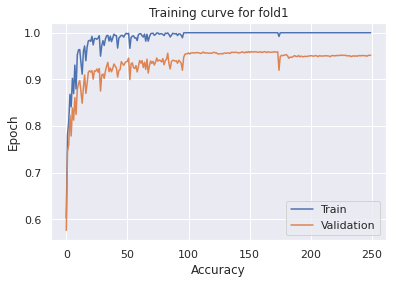

Epoch=0, Accuracy=0.6229146994019515
Epoch=10, Accuracy=0.8482845451683979
Epoch=20, Accuracy=0.9102927289896129
Epoch=30, Accuracy=0.9228832231665093
Epoch=40, Accuracy=0.9477494491658798
Epoch=50, Accuracy=0.9405099150141643
Epoch=60, Accuracy=0.9477494491658798
Epoch=70, Accuracy=0.9102927289896129
Epoch=80, Accuracy=0.9518413597733711
Epoch=90, Accuracy=0.9461756373937678
Epoch=100, Accuracy=0.9590808939250866
Epoch=110, Accuracy=0.9656909033679572
Epoch=120, Accuracy=0.9647466163046899
Epoch=130, Accuracy=0.9565627950897073
Epoch=140, Accuracy=0.9612842304060434
Epoch=150, Accuracy=0.9625432798237331
Epoch=160, Accuracy=0.9622285174693107
Epoch=170, Accuracy=0.9619137551148883
Epoch=180, Accuracy=0.9656909033679572
Epoch=190, Accuracy=0.9496380232924142
Epoch=200, Accuracy=0.9597104186339314
Epoch=210, Accuracy=0.9606547056971986
Epoch=220, Accuracy=0.960969468051621
Epoch=230, Accuracy=0.9619137551148883
Epoch=240, Accuracy=0.9622285174693107
Fold=2, Validation Accuracy=0.9628580

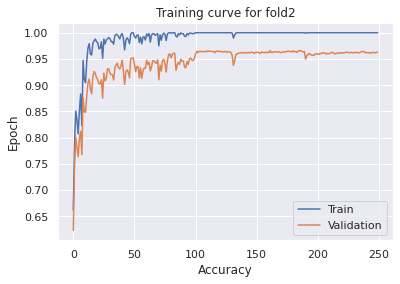

Epoch=0, Accuracy=0.5920679886685553
Epoch=10, Accuracy=0.8451369216241738
Epoch=20, Accuracy=0.9131255901794145
Epoch=30, Accuracy=0.9307522820270696
Epoch=40, Accuracy=0.8290840415486308
Epoch=50, Accuracy=0.9342146679257161
Epoch=60, Accuracy=0.9191060749134403
Epoch=70, Accuracy=0.9439723009128108
Epoch=80, Accuracy=0.9288637079005351
Epoch=90, Accuracy=0.937991816178785
Epoch=100, Accuracy=0.9578218445073969
Epoch=110, Accuracy=0.9571923197985521
Epoch=120, Accuracy=0.9590808939250866
Epoch=130, Accuracy=0.9408246773685868
Epoch=140, Accuracy=0.9631728045325779
Epoch=150, Accuracy=0.9619137551148883
Epoch=160, Accuracy=0.959395656279509
Epoch=170, Accuracy=0.9597104186339314
Epoch=180, Accuracy=0.9606547056971986
Epoch=190, Accuracy=0.9600251809883538
Epoch=200, Accuracy=0.9584513692162417
Epoch=210, Accuracy=0.9622285174693107
Epoch=220, Accuracy=0.9615989927604659
Epoch=230, Accuracy=0.9597104186339314
Epoch=240, Accuracy=0.9590808939250866
Fold=3, Validation Accuracy=0.95876613

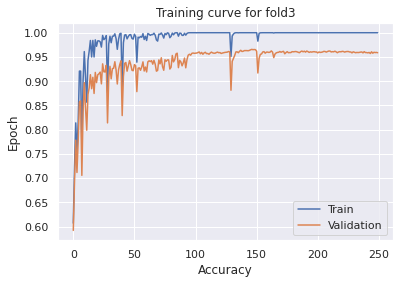

Epoch=0, Accuracy=0.542191435768262
Epoch=10, Accuracy=0.8853904282115869
Epoch=20, Accuracy=0.9263224181360201
Epoch=30, Accuracy=0.9376574307304786
Epoch=40, Accuracy=0.9159319899244333
Epoch=50, Accuracy=0.9404911838790933
Epoch=60, Accuracy=0.9304156171284634
Epoch=70, Accuracy=0.9379722921914357
Epoch=80, Accuracy=0.957808564231738
Epoch=90, Accuracy=0.9266372795969773
Epoch=100, Accuracy=0.9631612090680101
Epoch=110, Accuracy=0.966624685138539
Epoch=120, Accuracy=0.9663098236775819
Epoch=130, Accuracy=0.9659949622166247
Epoch=140, Accuracy=0.9609571788413098
Epoch=150, Accuracy=0.9653652392947103
Epoch=160, Accuracy=0.9663098236775819
Epoch=170, Accuracy=0.9663098236775819
Epoch=180, Accuracy=0.9672544080604534
Epoch=190, Accuracy=0.9458438287153652
Epoch=200, Accuracy=0.9625314861460957
Epoch=210, Accuracy=0.9659949622166247
Epoch=220, Accuracy=0.9644206549118388
Epoch=230, Accuracy=0.9641057934508817
Epoch=240, Accuracy=0.9653652392947103
Fold=4, Validation Accuracy=0.964735516

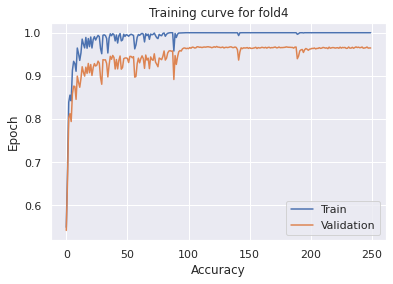

In [79]:
# ResNet34
EPOCHS = 250
oof_resnet34 = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = ResNet34().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")

    # Validation
    probs, targs = engine.evaluate(valid_loader, model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()
    
    oof_resnet34[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(model.state_dict(), f"../models/resnet34-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
np.save("../input/processed/oof-train-resnet34", oof_resnet34)

In [80]:
# oof_resnet34 = np.load("../input/processed/oof-train-resnet34.npy")
# targs_oof = np.load("../input/processed/targs-train-oof.npy")
preds_oof_resnet34 = np.argmax(oof_resnet34, axis=1)
accuracy = metrics.accuracy_score(targs_oof, preds_oof_resnet34)
print(f"CV Accuracy Score={accuracy}")

CV Accuracy Score=0.9593930999748175


### ResNet50

In [38]:
# ResNet50
EPOCHS = 250
MIXUP = True
oof_resnet50 = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)

    if MIXUP:
        train_dataset = dataset.Mixup(train_dataset, num_mix=2)
    
    valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = ResNet50().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        
        if not MIXUP:
            # Get training accuracy
            train_probs, train_targs = engine.evaluate(train_loader, model, device)
            train_preds = np.argmax(train_probs, axis=1)
            train_accuracy = metrics.accuracy_score(train_targs, train_preds)
            train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")

    if not MIXUP:
        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.xlabel("Accuracy")
        plt.ylabel("Epoch")
        plt.legend()
        plt.show()
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    oof_resnet50[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(model.state_dict(), f"../models/resnet50-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-resnet50", oof_resnet50)

Epoch=0, Accuracy=0.38243626062322944
Epoch=10, Accuracy=0.7582625118035883
Epoch=20, Accuracy=0.7891092225369846
Epoch=30, Accuracy=0.846081208687441
Epoch=40, Accuracy=0.8942398489140698
Epoch=50, Accuracy=0.9184765502045955
Epoch=60, Accuracy=0.8180673591438464
Epoch=70, Accuracy=0.9046270066100094
Epoch=80, Accuracy=0.9008498583569405
Epoch=90, Accuracy=0.92036512433113
Epoch=100, Accuracy=0.9030531948378974
Epoch=110, Accuracy=0.9342146679257161
Epoch=120, Accuracy=0.9335851432168712
Epoch=130, Accuracy=0.9291784702549575
Epoch=140, Accuracy=0.9298079949638023
Epoch=150, Accuracy=0.9354737173434057
Epoch=160, Accuracy=0.936418004406673
Epoch=170, Accuracy=0.9386213408876298
Epoch=180, Accuracy=0.9411394397230092
Epoch=190, Accuracy=0.9411394397230092
Epoch=200, Accuracy=0.939565627950897
Epoch=210, Accuracy=0.9357884796978282
Epoch=220, Accuracy=0.9357884796978282
Epoch=230, Accuracy=0.9370475291155178
Epoch=240, Accuracy=0.9386213408876298
Fold=0, Validation Accuracy=0.9376770538

KeyboardInterrupt: 

In [ ]:
# oof_resnet50 = np.load("../input/processed/oof-train-resnet50.npy")
# targs_oof = np.load("../input/processed/targs-train-oof.npy")
preds_oof_resnet50 = np.argmax(oof_resnet50, axis=1)
accuracy_resnet50 = metrics.accuracy_score(targs_oof, preds_oof_resnet50)
print(f"CV Accuracy Score={accuracy_resnet50}")

## EfficientNet

### Model definitions

In [8]:
def EfficientNetB0():
    model = EfficientNet.from_name("efficientnet-b0", image_size=28, num_classes=10)
    model._fc = nn.Linear(1280, 10)
    return model

def EfficientNetB1():
    model = EfficientNet.from_name("efficientnet-b1", image_size=28)
    model._fc = nn.Linear(1280, 10)
    return model

def EfficientNetB2():
    model = EfficientNet.from_name("efficientnet-b2", image_size=28)
    model._fc = nn.Linear(1408, 10)
    return model

def EfficientNetB3():
    model = EfficientNet.from_name("efficientnet-b3", image_size=28)
    model._fc = nn.Linear(1536, 10)
    return model
    
def EfficientNetB4():
    model = EfficientNet.from_name("efficientnet-b4", image_size=28)
    model._fc = nn.Linear(1792, 10)
    return model

def EfficientNetB5():
    model = EfficientNet.from_name("efficientnet-b5", image_size=28)
    model._fc = nn.Linear(2048, 10)
    return model

def EfficientNetB6():
    model = EfficientNet.from_name("efficientnet-b6", image_size=28)
    model._fc = nn.Linear(2304, 10)
    return model

def EfficientNetB7():
    model = EfficientNet.from_name("efficientnet-b7", image_size=28)
    model._fc = nn.Linear(2560, 10)
    return model

def EfficientNetB8():
    model = EfficientNet.from_name("efficientnet-b8", image_size=28)
    model._fc = nn.Linear(2816, 10)
    return model

def EfficientNetL2():
    model = EfficientNet.from_name("efficientnet-l2", image_size=28)
    model._fc = nn.Linear(5504, 10)
    return model

### EfficientNet-B0

Epoch=0, Accuracy=0.4696254327982373
Epoch=10, Accuracy=0.9329556185080264
Epoch=20, Accuracy=0.9137551148882593
Epoch=30, Accuracy=0.9512118350645263
Epoch=40, Accuracy=0.9634875668870003
Epoch=50, Accuracy=0.9590808939250866
Epoch=60, Accuracy=0.9691532892666037
Epoch=70, Accuracy=0.9710418633931381
Epoch=80, Accuracy=0.9735599622285175
Epoch=90, Accuracy=0.9732451998740951
Epoch=100, Accuracy=0.9726156751652503
Epoch=110, Accuracy=0.9738747245829399
Epoch=120, Accuracy=0.9732451998740951
Epoch=130, Accuracy=0.9729304375196727
Epoch=140, Accuracy=0.9726156751652503
Epoch=150, Accuracy=0.9741894869373623
Epoch=160, Accuracy=0.9745042492917847
Epoch=170, Accuracy=0.9738747245829399
Epoch=180, Accuracy=0.9735599622285175
Epoch=190, Accuracy=0.9729304375196727
Fold=0, Validation Accuracy=0.9732451998740951


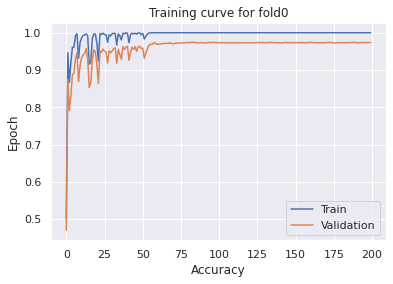

Epoch=0, Accuracy=0.32137236386528173
Epoch=10, Accuracy=0.9276046584828455
Epoch=20, Accuracy=0.9370475291155178
Epoch=30, Accuracy=0.9335851432168712
Epoch=40, Accuracy=0.9578218445073969
Epoch=50, Accuracy=0.9531004091910608
Epoch=60, Accuracy=0.9619137551148883
Epoch=70, Accuracy=0.9628580421781555
Epoch=80, Accuracy=0.9694680516210261
Epoch=90, Accuracy=0.9723009128108279
Epoch=100, Accuracy=0.9713566257475605
Epoch=110, Accuracy=0.9716713881019831
Epoch=120, Accuracy=0.9723009128108279
Epoch=130, Accuracy=0.9729304375196727
Epoch=140, Accuracy=0.9729304375196727


In [ ]:
# EfficientNet-B0
EPOCHS = 200
oof_effnb0 = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=768)

    model = models.EfficientNetB0().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=0.256, alpha=0.9, weight_decay=1e-5, momentum=0.9)
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.97 ** (epoch / 2.4))
    scaler = torch.cuda.amp.GradScaler()
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler)
        
         # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")

    # Validation
    probs, targs = engine.evaluate(valid_loader, model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()
    
    oof_effnb0[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(model.state_dict(), f"../models/efficientnet-b0-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-efficientnet-b0", oof_effnb0)

In [ ]:
# oof5 = np.load("../input/processed/oof-train-efficientnet-b0.npy")
# targs_oof5 = np.load("../input/processed/targs-train-oof.npy")
preds_oof_effnb0 = np.argmax(oof_effnb0, axis=1)
accuracy_oof = metrics.accuracy_score(targs_oof, preds_oof_effnb0)
print(f"CV Accuracy Score={accuracy_oof}")

In [ ]:
del model
torch.cuda.empty_cache()
gc.collect()

## Inference

### 1-input channel models

In [81]:
df_test = pd.read_csv("../input/test.csv")
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [82]:
probs_test = np.zeros((len(df_test), 10))

In [83]:
# model = models.Model()
# swa_model = AveragedModel(model)
# swa_model.load_state_dict(torch.load("../models/baseline-swa-4.pth"))
# swa_model.to(device)
# probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

In [84]:
model = models.SpinalVGG()
swa_model = AveragedModel(model)
swa_model.load_state_dict(torch.load("../models/spinalvgg-swa-0.pth"))
swa_model.to(device)
probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

### 3-input channel models

In [88]:
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False, rgb=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [89]:
model = ResNet34()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/resnet34-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

In [ ]:
model = models.EfficientNetB0()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/efficientnet-b0-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

### Submission

In [90]:
preds_test = np.argmax(probs_test, axis=1)

In [91]:
submission = pd.DataFrame({"id": df_test.id, "digit": preds_test})
submission.to_csv("../output/baseline+spinalvgg+resnet34.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
